# Демонстрация Наблюдателя (Observer Demo)

Этот ноутбук демонстрирует работу **GlobalObserver** — наблюдателя, который:
1. Проецирует 1D микросостояние в 3D IFACE (интерфейс)
2. Обучается физическим законам из наблюдений
3. Проверяет законы сохранения

## Архитектура триады (E_τ, O, M)

```
E_τ: World.step()     — Эволюция 1D мира по RULESET
O:   Observer.observe() — Проекция Π_obs: S → IFACE
M:   (пассивный)       — Наблюдатель не вмешивается
```

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import importlib

# Очистка кэша модулей world
for mod_name in list(sys.modules.keys()):
    if mod_name.startswith('world'):
        del sys.modules[mod_name]

# Импорт модулей симулятора
from world.core import Lattice, LatticeState, Rule, RuleSet, EvolutionEngine
from world.omega import CycleDetector
from world.observer import (
    GlobalObserver, ObserverConfig,
    MortonMapper, morton_decode,
    IFACEObject, IFACEState, SemanticState
)

print("✓ Импорт успешен")

✓ Импорт успешен


## 1. Настройка мира и наблюдателя

Используем найденные SM-подобные правила:
- `++- ↔ -++` (обмен зарядами)
- `+++ → +++` (стабилизатор)

In [2]:
# SM-подобные правила
SM_RULES = RuleSet([
    Rule(name="charge_swap",     pattern=[1, 1, -1], replacement=[-1, 1, 1]),
    Rule(name="charge_swap_inv", pattern=[-1, 1, 1], replacement=[1, 1, -1]),
    Rule(name="stabilizer",      pattern=[1, 1, 1],  replacement=[1, 1, 1]),
])

print("SM-правила:")
for rule in SM_RULES.rules:
    print(f"  {rule}")

SM-правила:
  Rule('charge_swap': ++- → -++)
  Rule('charge_swap_inv': -++ → ++-)
  Rule('stabilizer': +++ → +++)


In [3]:
# Размер решётки: N = 16³ = 4096 для полного 3D отображения
# Для демо используем меньший размер для скорости
N = 512  # 8³
ORDER = 3  # 2^3 = 8

# Создаём решётку
lattice = Lattice.random(size=N, p_plus=0.95, seed=42)

# Проверяем
state = lattice.to_state()
n_plus = np.sum(state.sites == 1)
n_minus = np.sum(state.sites == -1)

print(f"Решётка: N={N}")
print(f"Начальное состояние: +{n_plus} / -{n_minus}")

Решётка: N=512
Начальное состояние: +493 / -19


In [4]:
# Конфигурация наблюдателя
config = ObserverConfig(
    lattice_size=N,
    grid_order=ORDER,      # 8³ сетка
    coarse_radius=2,       # R для ϕ_R
    C0=2.0,                # Базовая ёмкость
    alpha=0.5,             # Связь tension-capacity
    fit_every=10,          # Fit уравнения каждые 10 шагов
)

# Создаём наблюдателя
observer = GlobalObserver(config)
print(f"Наблюдатель создан: {observer}")

Наблюдатель создан: GlobalObserver(t=0, τ=0.00, SemanticState(LEARNING, t_OT=0, FieldEq(κ=0.0000, m²=0.0000, λ=0.0000, R²=0.000), Q=✗, M=✗))


## 2. Демонстрация Z-order (Morton) отображения

Morton код отображает 1D индексы в 3D координаты с сохранением локальности.

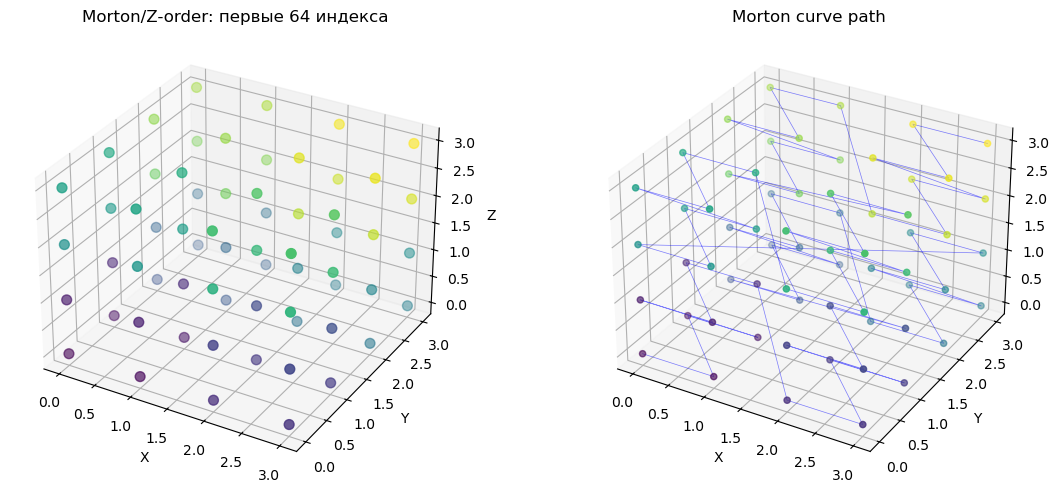


Примеры преобразования:
    0 → (0, 0, 0)
    1 → (1, 0, 0)
    7 → (1, 1, 1)
    8 → (2, 0, 0)
   63 → (3, 3, 3)
  100 → (4, 0, 3)
  200 → (6, 4, 0)


In [5]:
# Визуализация Morton mapping
mapper = MortonMapper(order=ORDER)

# Покажем первые 64 индекса
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
coords = mapper.map_all_discrete(64)
ax1.scatter(coords[:,0], coords[:,1], coords[:,2], 
            c=np.arange(64), cmap='viridis', s=50)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Morton/Z-order: первые 64 индекса')

# Показать путь
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(coords[:,0], coords[:,1], coords[:,2], 'b-', alpha=0.5, linewidth=0.5)
ax2.scatter(coords[:,0], coords[:,1], coords[:,2], 
            c=np.arange(64), cmap='viridis', s=20)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Morton curve path')

plt.tight_layout()
plt.show()

print(f"\nПримеры преобразования:")
for i in [0, 1, 7, 8, 63, 100, 200]:
    x, y, z = morton_decode(i % mapper.total_size)
    print(f"  {i:3d} → ({x}, {y}, {z})")

## 3. Цикл наблюдения

Запускаем эволюцию мира и наблюдение через IFACE.

In [6]:
# Evolution engine
engine = EvolutionEngine(SM_RULES)

# Детектор Ω-циклов
detector = CycleDetector(window_size=5, max_period=50)

# История для анализа
iface_states = []
semantic_snapshots = []

T_MAX = 100

print("Запуск симуляции...")
for t in range(T_MAX):
    # E_τ: Эволюция мира
    applied_rules = engine.step(lattice)
    
    # Детекция Ω-циклов
    state = lattice.to_state()
    detector.update(state.sites, t)
    cycles = detector.get_active_cycles(t, max_age=100)
    
    # O: Наблюдение
    iface = observer.observe(lattice, cycles)
    iface_states.append(iface)
    
    # Обновление семантики (обучение)
    observer.update_semantics()
    
    # Сохраняем snapshot семантики каждые 20 шагов
    if t % 20 == 0:
        semantic_snapshots.append({
            't': t,
            'summary': observer.knowledge
        })
    
    if t % 25 == 0:
        print(f"  t={t:3d}: объектов={iface.num_objects}, Q={iface.total_Q:+.1f}, "
              f"M={iface.total_mass:.2f}, τ={observer.tau:.2f}")

print(f"\nСимуляция завершена: {T_MAX} шагов")
print(f"Финальное состояние наблюдателя: {observer}")

Запуск симуляции...
  t=  0: объектов=0, Q=+0.0, M=0.00, τ=0.96
  t= 25: объектов=998, Q=+4.0, M=967.87, τ=25.04
  t= 25: объектов=998, Q=+4.0, M=967.87, τ=25.04
  t= 50: объектов=2156, Q=-1.0, M=1285.74, τ=49.11
  t= 50: объектов=2156, Q=-1.0, M=1285.74, τ=49.11
  t= 75: объектов=3231, Q=+16.0, M=1458.78, τ=73.18
  t= 75: объектов=3231, Q=+16.0, M=1458.78, τ=73.18

Симуляция завершена: 100 шагов
Финальное состояние наблюдателя: GlobalObserver(t=100, τ=96.29, SemanticState(LEARNING, t_OT=10, FieldEq(κ=0.2612, m²=0.2116, λ=-0.2279, R²=0.340), Q=✓, M=✓))

Симуляция завершена: 100 шагов
Финальное состояние наблюдателя: GlobalObserver(t=100, τ=96.29, SemanticState(LEARNING, t_OT=10, FieldEq(κ=0.2612, m²=0.2116, λ=-0.2279, R²=0.340), Q=✓, M=✓))


## 4. Результаты обучения наблюдателя

Смотрим, что наблюдатель "выучил" о мире.

In [7]:
# Получаем знания наблюдателя
knowledge = observer.knowledge

print("=" * 60)
print("ЗНАНИЯ НАБЛЮДАТЕЛЯ (S_sem)")
print("=" * 60)

print("\n📐 Полевое уравнение: ∂²ϕ/∂t² = κ∇²ϕ - m²ϕ - λϕ³")
fe = knowledge['field_equation']
print(f"   κ  = {fe['kappa']:.6f}")
print(f"   m² = {fe['m2']:.6f}")
print(f"   λ  = {fe['lambda']:.6f}")
print(f"   R² = {fe['r_squared']:.4f}")

print("\n⚖️ Законы сохранения:")
cons = knowledge['conservation']
q_status = "✓ СОХРАНЯЕТСЯ" if cons['Q']['conserved'] else "✗ нарушается"
m_status = "✓ СОХРАНЯЕТСЯ" if cons['mass']['conserved'] else "✗ нарушается"
print(f"   Заряд Q: {q_status} (уверенность: {cons['Q']['confidence']:.2f})")
print(f"   Масса M: {m_status} (уверенность: {cons['mass']['confidence']:.2f})")

print("\n🌍 Гравитационный закон: a = -γ∇Φ")
grav = knowledge['gravity']
print(f"   γ    = {grav['gamma']:.6f}")
print(f"   corr = {grav['correlation']:.4f}")

print("\n⏱️ Observation Time:")
if knowledge['stabilized']:
    print(f"   t_OT = {knowledge['observation_time']} (понимание стабилизировалось)")
else:
    print(f"   Ещё обучается (текущий t = {knowledge['total_updates']})")

ЗНАНИЯ НАБЛЮДАТЕЛЯ (S_sem)

📐 Полевое уравнение: ∂²ϕ/∂t² = κ∇²ϕ - m²ϕ - λϕ³
   κ  = 0.261205
   m² = 0.211626
   λ  = -0.227950
   R² = 0.3399

⚖️ Законы сохранения:
   Заряд Q: ✓ СОХРАНЯЕТСЯ (уверенность: 1.00)
   Масса M: ✓ СОХРАНЯЕТСЯ (уверенность: 1.00)

🌍 Гравитационный закон: a = -γ∇Φ
   γ    = -0.032388
   corr = -0.0446

⏱️ Observation Time:
   Ещё обучается (текущий t = 10)


## 5. Визуализация IFACE

Смотрим, как выглядит мир в интерфейсе наблюдателя.

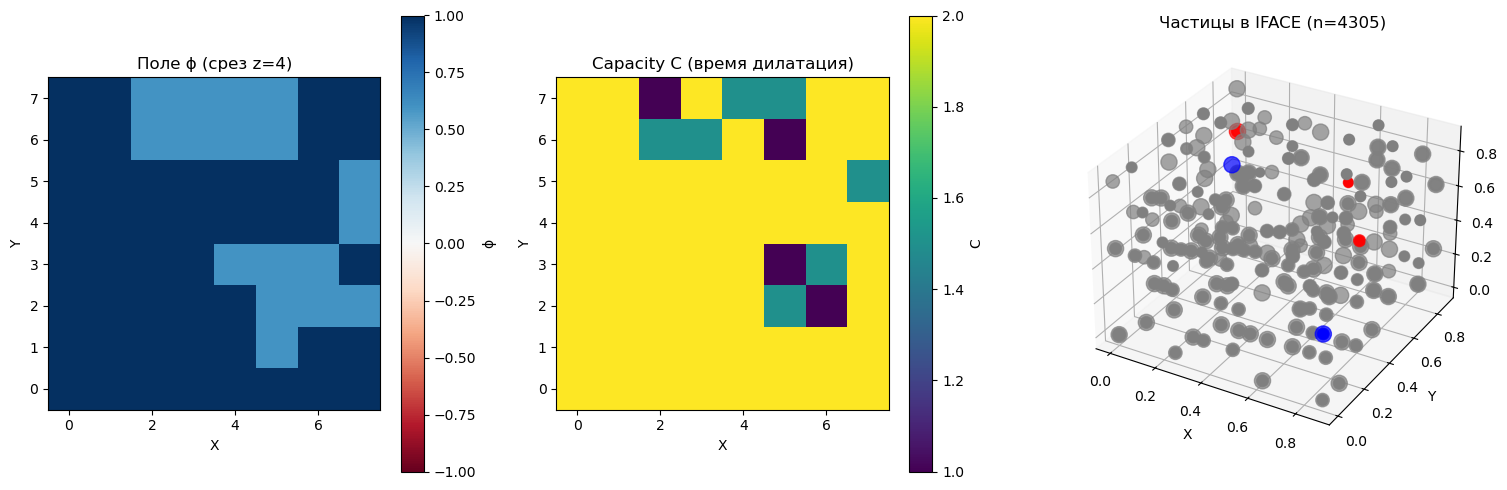


Статистика IFACE на t=99:
  Объектов: 4305
  Общий заряд Q: +22.00
  Общая масса M: 1583.15
  Собственное время τ: 96.29


In [8]:
# Берём последнее состояние IFACE
last_iface = iface_states[-1]

fig = plt.figure(figsize=(15, 5))

# 1. Поле ϕ (срез z=4)
ax1 = fig.add_subplot(131)
if last_iface.field is not None:
    phi_slice = last_iface.field.phi[:, :, mapper.dim_size//2]
    im1 = ax1.imshow(phi_slice, cmap='RdBu', origin='lower', vmin=-1, vmax=1)
    plt.colorbar(im1, ax=ax1, label='ϕ')
ax1.set_title(f'Поле ϕ (срез z={mapper.dim_size//2})')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# 2. Capacity (метрика времени)
ax2 = fig.add_subplot(132)
if last_iface.field is not None:
    C_slice = last_iface.field.capacity[:, :, mapper.dim_size//2]
    im2 = ax2.imshow(C_slice, cmap='viridis', origin='lower')
    plt.colorbar(im2, ax=ax2, label='C')
ax2.set_title(f'Capacity C (время дилатация)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

# 3. Объекты (частицы) в 3D
ax3 = fig.add_subplot(133, projection='3d')
if last_iface.objects:
    xs = [o.pos[0] for o in last_iface.objects]
    ys = [o.pos[1] for o in last_iface.objects]
    zs = [o.pos[2] for o in last_iface.objects]
    masses = [o.mass for o in last_iface.objects]
    charges = [o.Q for o in last_iface.objects]
    
    colors = ['red' if q > 0 else 'blue' if q < 0 else 'gray' for q in charges]
    sizes = [50 * m + 10 for m in masses]
    
    ax3.scatter(xs, ys, zs, c=colors, s=sizes, alpha=0.7)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
ax3.set_title(f'Частицы в IFACE (n={last_iface.num_objects})')

plt.tight_layout()
plt.show()

print(f"\nСтатистика IFACE на t={last_iface.t}:")
print(f"  Объектов: {last_iface.num_objects}")
print(f"  Общий заряд Q: {last_iface.total_Q:+.2f}")
print(f"  Общая масса M: {last_iface.total_mass:.2f}")
print(f"  Собственное время τ: {last_iface.tau:.2f}")

## 6. Законы сохранения (Conservation Laws)

**Ключевой инвариант**: Глобальный топологический заряд = число доменных стенок:
$$Q_{global} = N(+\to-) + N(-\to+)$$

Для SM-правил `++- ↔ -++` это число **строго сохраняется**, потому что swap перемещает стенку, но не создаёт/уничтожает её.

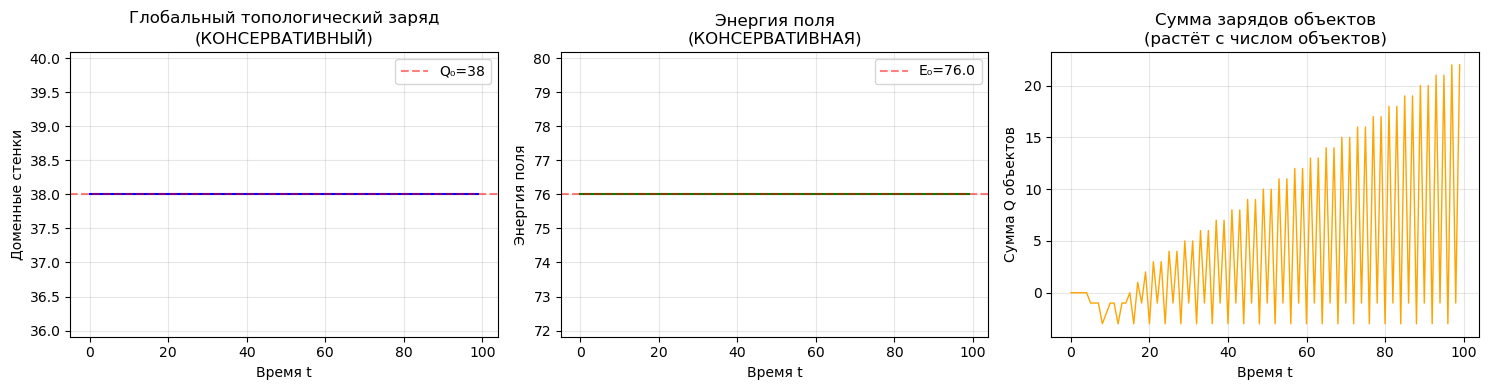

Глобальный заряд: начальный=38, финальный=38, ΔQ=0.0
Энергия поля: начальная=76.00, финальная=76.00, ΔE=0.000

✓ Q сохраняется: True
✓ E сохраняется: True


In [9]:
# История законов сохранения
# global_Q = число доменных стенок (топологически консервативно)
# total_Q = сумма зарядов объектов (растёт с числом объектов)
global_Q_history = observer.iface_history.get_global_Q_history()
total_Q_history = observer.iface_history.get_total_Q_history()
field_energy_history = observer.iface_history.get_field_energy_history()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Глобальный топологический заряд (доменные стенки)
ax1 = axes[0]
ax1.plot(global_Q_history, 'b-', linewidth=1.5)
ax1.axhline(global_Q_history[0], color='r', linestyle='--', alpha=0.5, label=f'Q₀={global_Q_history[0]:.0f}')
ax1.set_xlabel('Время t')
ax1.set_ylabel('Доменные стенки')
ax1.set_title('Глобальный топологический заряд\n(КОНСЕРВАТИВНЫЙ)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Энергия поля
ax2 = axes[1]
ax2.plot(field_energy_history, 'g-', linewidth=1.5)
ax2.axhline(field_energy_history[0], color='r', linestyle='--', alpha=0.5, label=f'E₀={field_energy_history[0]:.1f}')
ax2.set_xlabel('Время t')
ax2.set_ylabel('Энергия поля')
ax2.set_title('Энергия поля\n(КОНСЕРВАТИВНАЯ)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Сумма зарядов объектов (для сравнения)
ax3 = axes[2]
ax3.plot(total_Q_history, 'orange', linewidth=1)
ax3.set_xlabel('Время t')
ax3.set_ylabel('Сумма Q объектов')
ax3.set_title('Сумма зарядов объектов\n(растёт с числом объектов)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика сохранения
dQ = abs(global_Q_history[-1] - global_Q_history[0])
dE = abs(field_energy_history[-1] - field_energy_history[0])
print(f"Глобальный заряд: начальный={global_Q_history[0]:.0f}, финальный={global_Q_history[-1]:.0f}, ΔQ={dQ:.1f}")
print(f"Энергия поля: начальная={field_energy_history[0]:.2f}, финальная={field_energy_history[-1]:.2f}, ΔE={dE:.3f}")
print(f"\n✓ Q сохраняется: {dQ < 1.0}")
print(f"✓ E сохраняется: {dE / (field_energy_history[0] + 1e-10) < 0.01}")

## 7. Эволюция понимания (S_sem trajectory)

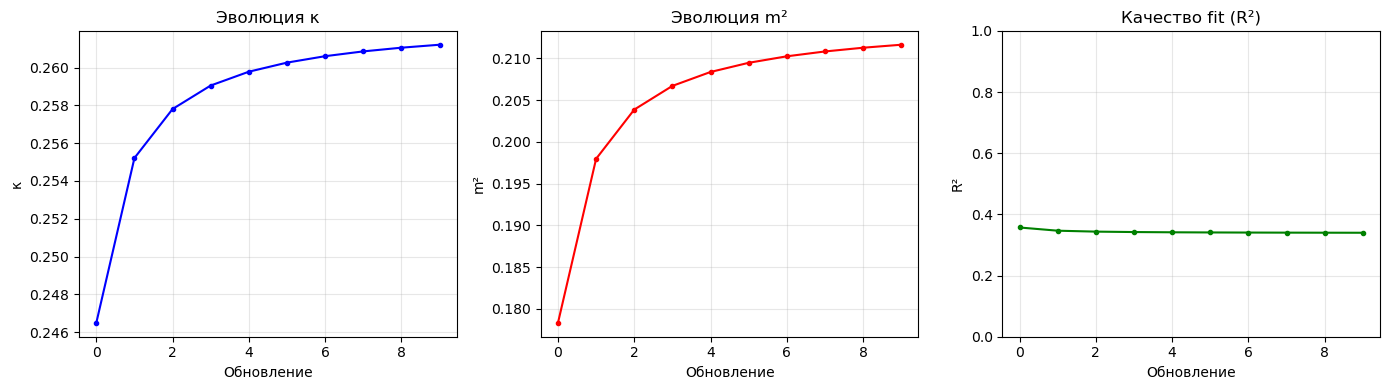

In [10]:
# Траектория параметров полевого уравнения
if observer.semantic_state.field_eq_history:
    kappa_traj = [p.kappa for p in observer.semantic_state.field_eq_history]
    m2_traj = [p.m2 for p in observer.semantic_state.field_eq_history]
    r2_traj = [p.r_squared for p in observer.semantic_state.field_eq_history]
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    ax1 = axes[0]
    ax1.plot(kappa_traj, 'b-o', markersize=3)
    ax1.set_xlabel('Обновление')
    ax1.set_ylabel('κ')
    ax1.set_title('Эволюция κ')
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    ax2.plot(m2_traj, 'r-o', markersize=3)
    ax2.set_xlabel('Обновление')
    ax2.set_ylabel('m²')
    ax2.set_title('Эволюция m²')
    ax2.grid(True, alpha=0.3)
    
    ax3 = axes[2]
    ax3.plot(r2_traj, 'g-o', markersize=3)
    ax3.set_xlabel('Обновление')
    ax3.set_ylabel('R²')
    ax3.set_title('Качество fit (R²)')
    ax3.set_ylim([0, 1])
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("История полевого уравнения пуста (недостаточно данных для fit)")

## 8. Итоги

### Что было реализовано:

1. **Z-order (Morton) mapping** — отображение 1D → 3D с сохранением локальности
2. **IFACE структуры** — интерфейс наблюдателя с объектами и полями
3. **SemanticState** — знания наблюдателя (κ, m², λ, законы сохранения)
4. **GlobalObserver** — полный цикл наблюдения и обучения

### Триада E_τ, O, M:

- **E_τ** (эволюция): `engine.step(lattice)` по SM-правилам
- **O** (наблюдение): `observer.observe()` → IFACE
- **M** (материализация): пассивный режим (без вмешательства)

### Следующие шаги:

- Добавить TDA анализ (β₀, β₁) для траектории понимания
- Интегрировать OBSFitness в эволюционный поиск
- Реализовать эксперимент "падения" частицы в гравполе

In [11]:
print("=" * 60)
print("ИТОГОВАЯ СТАТИСТИКА")
print("=" * 60)
print(f"Шагов симуляции: {T_MAX}")
print(f"Размер решётки: {N} (= {mapper.dim_size}³)")
print(f"Собственное время наблюдателя: τ = {observer.tau:.3f}")
print(f"Обновлений семантики: {observer.semantic_state.update_count}")
print(f"Стабилизация: {'Да' if observer.semantic_state.is_stabilized() else 'Нет'}")
print("=" * 60)

ИТОГОВАЯ СТАТИСТИКА
Шагов симуляции: 100
Размер решётки: 512 (= 8³)
Собственное время наблюдателя: τ = 96.289
Обновлений семантики: 10
Стабилизация: Нет


## 7. OBSFitness - Метрики для эволюционного поиска

Оцениваем качество извлечения физики наблюдателем:

OBSFitness - МЕТРИКИ НАБЛЮДАТЕЛЯ

🎯 Общий OBSFitness: 0.6043

Компоненты:
  📐 Полевое уравнение: 0.3399 (R²=0.340)
  ⚡ Сохранение заряда Q: 1.0000 (violation=0.000)
  ⚖️  Сохранение массы M: 1.0000 (violation=0.000)
  ⏱️  Observation Time: 0.6703 (t_OT=10, stable=False)
  🌍 Гравитация: 0.0223 (corr=0.045)
  🎲 Вероятности: 0.5000


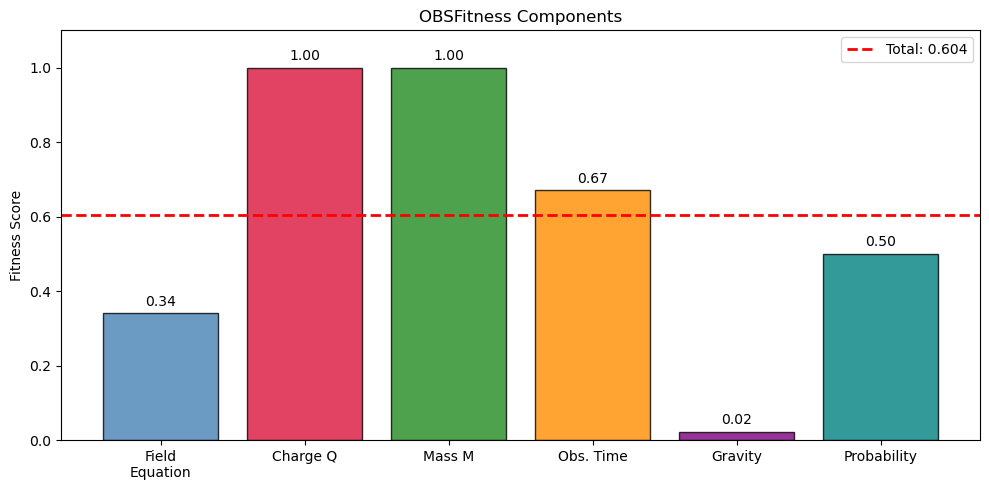

In [12]:
# Перезагрузка модулей после добавления новых
import importlib
import world.observer
import world.observer.fitness
import world.observer.tda
importlib.reload(world.observer.fitness)
importlib.reload(world.observer.tda)
importlib.reload(world.observer)

from world.observer import OBSFitness, OBSFitnessConfig, evaluate_observer_fitness

# Вычисляем OBSFitness
obs_fitness = OBSFitness(OBSFitnessConfig(
    sigma_field=0.1,
    sigma_Q=0.1,
    T_scale_fraction=0.25,
    w_field=1.0,
    w_Q=1.0,
    w_mass=0.5,
    w_OT=1.0,
))

score, components = obs_fitness.evaluate(observer, T_total=T_MAX)

print("=" * 60)
print("OBSFitness - МЕТРИКИ НАБЛЮДАТЕЛЯ")
print("=" * 60)
print(f"\n🎯 Общий OBSFitness: {score:.4f}")
print(f"\nКомпоненты:")
print(f"  📐 Полевое уравнение: {components.fitness_field:.4f} (R²={components.field_r_squared:.3f})")
print(f"  ⚡ Сохранение заряда Q: {components.fitness_Q:.4f} (violation={components.Q_violation:.3f})")
print(f"  ⚖️  Сохранение массы M: {components.fitness_mass:.4f} (violation={components.mass_violation:.3f})")
print(f"  ⏱️  Observation Time: {components.fitness_OT:.4f} (t_OT={components.t_OT}, stable={components.is_stabilized})")
print(f"  🌍 Гравитация: {components.fitness_gravity:.4f} (corr={components.gravity_correlation:.3f})")
print(f"  🎲 Вероятности: {components.fitness_prob:.4f}")

# Визуализация компонент
fig, ax = plt.subplots(figsize=(10, 5))

labels = ['Field\nEquation', 'Charge Q', 'Mass M', 'Obs. Time', 'Gravity', 'Probability']
values = [
    components.fitness_field,
    components.fitness_Q, 
    components.fitness_mass,
    components.fitness_OT,
    components.fitness_gravity,
    components.fitness_prob
]
colors = ['steelblue', 'crimson', 'forestgreen', 'darkorange', 'purple', 'teal']

bars = ax.bar(labels, values, color=colors, edgecolor='black', alpha=0.8)
ax.axhline(y=score, color='red', linestyle='--', linewidth=2, label=f'Total: {score:.3f}')
ax.set_ylabel('Fitness Score')
ax.set_title('OBSFitness Components')
ax.set_ylim(0, 1.1)
ax.legend()

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 8. TDA - Топологический анализ траектории семантики

Анализируем структуру траектории обучения через персистентную гомологию:
- β₀ - число связных компонент (концептуальные кластеры)
- β₁ - число "петель" (циклические паттерны понимания)

In [13]:
from world.observer import SemanticTDA, analyze_semantic_trajectory

# Топологический анализ семантической траектории
tda_analyzer = SemanticTDA(n_scales=50)
summary, analysis = tda_analyzer.analyze(observer.semantic_history)

print("=" * 60)
print("TDA - ТОПОЛОГИЧЕСКИЙ АНАЛИЗ ТРАЕКТОРИИ")
print("=" * 60)

print(f"\n📊 Числа Бетти (на шкале ε={summary.scale:.3f}):")
print(f"   β₀ = {summary.beta_0} (связные компоненты)")
print(f"   β₁ = {summary.beta_1} (петли/циклы)")

print(f"\n📈 Персистентность:")
print(f"   H₀: total={summary.total_persistence_0:.3f}, max={summary.max_persistence_0:.3f}, значимых={summary.n_significant_0}")
print(f"   H₁: total={summary.total_persistence_1:.3f}, max={summary.max_persistence_1:.3f}, значимых={summary.n_significant_1}")
print(f"   Энтропия персистентности: {summary.persistence_entropy:.3f}")

print(f"\n🔍 Интерпретация:")
print(f"   Связность: {analysis['connectivity']} - {analysis['connectivity_desc']}")
print(f"   Структура: {analysis['structure']} - {analysis['structure_desc']}")
print(f"   Сходимость: {analysis['convergence']}")
print(f"   Сложность: {analysis['complexity_score']:.3f}")

TDA - ТОПОЛОГИЧЕСКИЙ АНАЛИЗ ТРАЕКТОРИИ

📊 Числа Бетти (на шкале ε=7.373):
   β₀ = 2 (связные компоненты)
   β₁ = 4152 (петли/циклы)

📈 Персистентность:
   H₀: total=39.085, max=14.451, значимых=3
   H₁: total=59605.374, max=14.451, значимых=4851
   Энтропия персистентности: 8.440

🔍 Интерпретация:
   Связность: clustered - 2 concept clusters
   Структура: complex - Complex structure with 4152 loops
   Сходимость: exploring
   Сложность: 2078.288


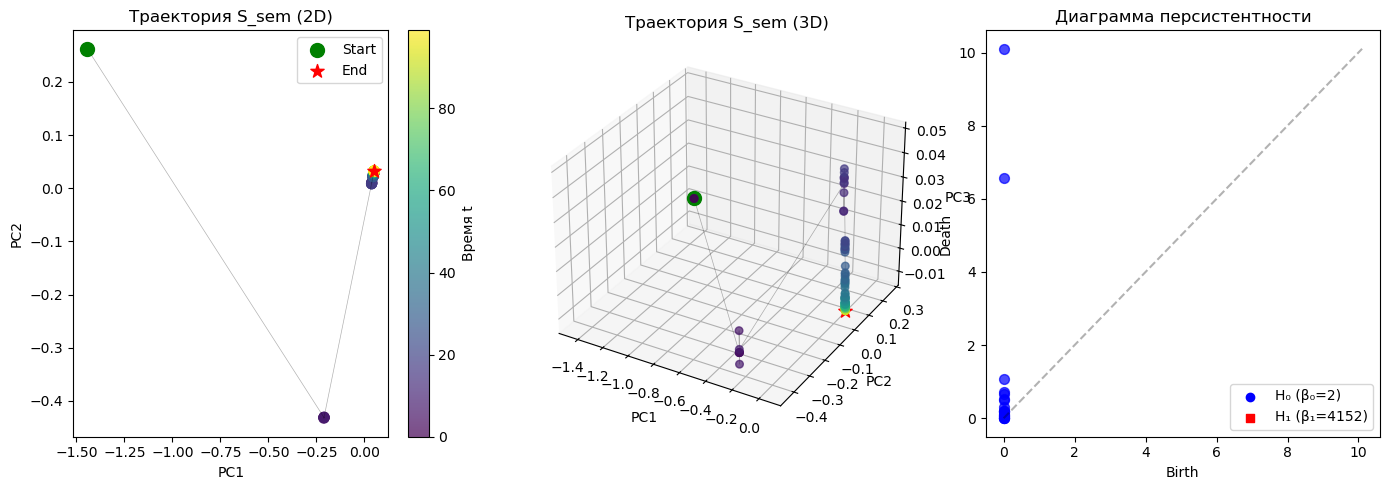

In [14]:
# Визуализация семантической траектории в пространстве параметров
vectors = observer.semantic_history.get_vectors_array()

if len(vectors) >= 3:
    # PCA для визуализации в 2D/3D
    from sklearn.decomposition import PCA
    
    fig = plt.figure(figsize=(14, 5))
    
    # 2D проекция
    ax1 = fig.add_subplot(131)
    if vectors.shape[1] > 2:
        pca2d = PCA(n_components=2)
        proj_2d = pca2d.fit_transform(vectors)
    else:
        proj_2d = vectors[:, :2]
    
    scatter = ax1.scatter(proj_2d[:, 0], proj_2d[:, 1], 
                          c=range(len(proj_2d)), cmap='viridis', 
                          s=50, alpha=0.7)
    ax1.plot(proj_2d[:, 0], proj_2d[:, 1], 'k-', alpha=0.3, linewidth=0.5)
    ax1.scatter(proj_2d[0, 0], proj_2d[0, 1], color='green', s=100, marker='o', label='Start', zorder=5)
    ax1.scatter(proj_2d[-1, 0], proj_2d[-1, 1], color='red', s=100, marker='*', label='End', zorder=5)
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_title('Траектория S_sem (2D)')
    ax1.legend()
    plt.colorbar(scatter, ax=ax1, label='Время t')
    
    # 3D проекция
    ax2 = fig.add_subplot(132, projection='3d')
    if vectors.shape[1] > 3:
        pca3d = PCA(n_components=3)
        proj_3d = pca3d.fit_transform(vectors)
    else:
        proj_3d = np.hstack([vectors, np.zeros((len(vectors), 3 - vectors.shape[1]))])[:, :3]
    
    ax2.scatter(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2],
                c=range(len(proj_3d)), cmap='viridis', s=30, alpha=0.7)
    ax2.plot(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], 'k-', alpha=0.3, linewidth=0.5)
    ax2.scatter([proj_3d[0, 0]], [proj_3d[0, 1]], [proj_3d[0, 2]], 
                color='green', s=100, marker='o', label='Start')
    ax2.scatter([proj_3d[-1, 0]], [proj_3d[-1, 1]], [proj_3d[-1, 2]], 
                color='red', s=100, marker='*', label='End')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_zlabel('PC3')
    ax2.set_title('Траектория S_sem (3D)')
    
    # Диаграмма персистентности (упрощённая)
    ax3 = fig.add_subplot(133)
    intervals = analysis.get('intervals', [])
    if intervals:
        for birth, death, dim in intervals:
            color = 'blue' if dim == 0 else 'red'
            marker = 'o' if dim == 0 else 's'
            ax3.scatter(birth, death, c=color, marker=marker, s=50, alpha=0.7)
        
        # Диагональ (короткоживущие фичи)
        max_val = max(max(d for _, d, _ in intervals), 1.0)
        ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)
        
        ax3.set_xlabel('Birth')
        ax3.set_ylabel('Death')
        ax3.set_title('Диаграмма персистентности')
        ax3.scatter([], [], c='blue', marker='o', label=f'H₀ (β₀={summary.beta_0})')
        ax3.scatter([], [], c='red', marker='s', label=f'H₁ (β₁={summary.beta_1})')
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'Недостаточно данных', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Диаграмма персистентности')
    
    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для визуализации траектории")

## 9. Интеграция с эволюционным поиском

Пример комбинированной функции фитнеса для совместной оптимизации правил и наблюдателя:

КОМБИНИРОВАННЫЙ ФИТНЕС ДЛЯ ЭВОЛЮЦИОННОГО ПОИСКА

Формула: TotalFitness = α·SMFitness + β·OBSFitness
         = 0.7·105.80 + 0.3·0.604
         = 74.06 + 0.181

🎯 TotalFitness = 74.241

📋 Для эволюционного поиска:
   • Оптимизируем RULESET → SMFitness (Ω-разнообразие, сохранение)
   • Оптимизируем OBS → OBSFitness (извлечение физики)
   • Совместно → TotalFitness


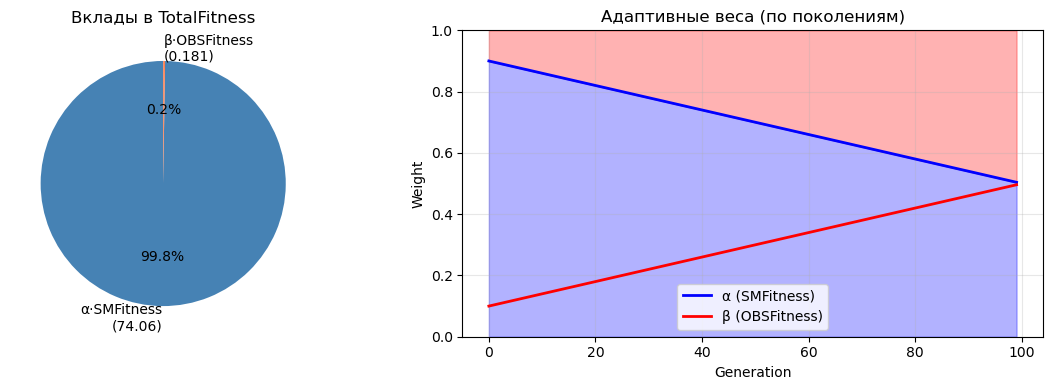

In [15]:
from world.observer import CombinedFitness, CombinedFitnessConfig

# Демонстрация формулы комбинированного фитнеса
# TotalFitness = α * SMFitness + β * OBSFitness

# Параметры
alpha = 0.7  # Вес SMFitness (микродинамика)
beta = 0.3   # Вес OBSFitness (семантика наблюдателя)

# Симуляция: предположим SMFitness уже вычислен
sm_fitness_score = 105.80  # Найденное ранее значение для SM-подобных правил

# OBSFitness вычислен выше
obs_fitness_score = score

# Комбинированный фитнес
total_fitness = alpha * sm_fitness_score + beta * obs_fitness_score

print("=" * 60)
print("КОМБИНИРОВАННЫЙ ФИТНЕС ДЛЯ ЭВОЛЮЦИОННОГО ПОИСКА")
print("=" * 60)
print(f"\nФормула: TotalFitness = α·SMFitness + β·OBSFitness")
print(f"         = {alpha}·{sm_fitness_score:.2f} + {beta}·{obs_fitness_score:.3f}")
print(f"         = {alpha * sm_fitness_score:.2f} + {beta * obs_fitness_score:.3f}")
print(f"\n🎯 TotalFitness = {total_fitness:.3f}")

print(f"\n📋 Для эволюционного поиска:")
print(f"   • Оптимизируем RULESET → SMFitness (Ω-разнообразие, сохранение)")
print(f"   • Оптимизируем OBS → OBSFitness (извлечение физики)")
print(f"   • Совместно → TotalFitness")

# Визуализация вкладов
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Вклады в общий фитнес
ax = axes[0]
contributions = [alpha * sm_fitness_score, beta * obs_fitness_score]
labels = [f'α·SMFitness\n({contributions[0]:.2f})', f'β·OBSFitness\n({contributions[1]:.3f})']
colors = ['steelblue', 'coral']
ax.pie(contributions, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title('Вклады в TotalFitness')

# Адаптивное изменение весов
ax = axes[1]
generations = np.arange(0, 100)
alpha_adaptive = 0.9 - 0.4 * (generations / 100)  # От 0.9 до 0.5
beta_adaptive = 1.0 - alpha_adaptive

ax.plot(generations, alpha_adaptive, 'b-', label='α (SMFitness)', linewidth=2)
ax.plot(generations, beta_adaptive, 'r-', label='β (OBSFitness)', linewidth=2)
ax.fill_between(generations, 0, alpha_adaptive, alpha=0.3, color='blue')
ax.fill_between(generations, alpha_adaptive, 1, alpha=0.3, color='red')
ax.set_xlabel('Generation')
ax.set_ylabel('Weight')
ax.set_title('Адаптивные веса (по поколениям)')
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()